## Model Training

Please ensure that you have python version greater or equal to 3.10 and less than or equal to 3.11. The newest version of Deepchem does not support python 3.12 yet.

In [1]:
# assert that python version is >=3.10 and <=3.11
import sys
assert sys.version_info >= (3, 10) and sys.version_info <= (3, 11) , "Python version not supported. Please use version 3.10 or 3.11"

Install the required packages

In [2]:
!pip install -r requirements.txt

## Import 

In [3]:
import deepchem as dc # requires python3<=3.11, numpy<2.0.0, tensorflow==2.15.0
dc.__version__

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


This module requires PyTorch to be installed.


2024-06-16 20:04:11.561824: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 20:04:11.582373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 20:04:11.582393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 20:04:11.582887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-16 20:04:11.587092: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


'2.8.1.dev'

You can build the training dataset yourself, or you can load the pre-built version from file. If you would like to load the pre-built dataset, feel free to ignore the next few cells.

In [4]:
dataset_file = 'train_set_no_oversampling.csv'
task = ['Biodegradation']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='smiles', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

In [5]:
dataset.to_dataframe().head()

,X,y,w,ids
0,<deepchem.feat.mol_graphs.ConvMol object at 0x...,1.0,1.0,O=Cc1ccco1
1,<deepchem.feat.mol_graphs.ConvMol object at 0x...,1.0,1.0,CCCCCCCCCCN(C)C
2,<deepchem.feat.mol_graphs.ConvMol object at 0x...,1.0,1.0,CCCCOC(=O)COC(=O)c1ccccc1C(=O)OCCCC
3,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,1.0,C=CCOC1=NS(=O)(=O)c2ccccc21
4,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,1.0,ClC1CCCCC1


Balance the dataset using Deepchem `BalancingTransformer`.

In [6]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
balanced_dataset = transformer.transform(dataset)

Save to disk

In [7]:
dc.utils.save_to_disk(balanced_dataset, 'balanced_dataset.joblib')

Alternatively, you can just run this to load the pre-built dataset from file.

In [8]:
balanced_dataset = dc.utils.load_from_disk('balanced_dataset.joblib')

Use the GraphConvModel from Deepchem with 0.2 dropout. Note that all checkpoints will be saved in the models directory.

In [47]:
model = dc.models.GraphConvModel(n_tasks=1, mode='classification', dropout=0.0, model_dir='models',)

In [48]:
model.fit(balanced_dataset, nb_epoch=60)

0.026144683361053467

Run the following cell to build the test set, or skip it and load the pre-built test set directly from file.

In [30]:
test_set = 'test_set.csv'
featurizer_func = dc.feat.ConvMolFeaturizer()
task = ['Biodegradation']

loader = dc.data.CSVLoader(feature_field='smiles', featurizer=featurizer_func, tasks=task)
test_dataset = loader.create_dataset(test_set)

dc.utils.save_to_disk(test_dataset, 'test_dataset.joblib')

Load the test dataset

In [12]:
test_dataset = dc.utils.load_from_disk('test_dataset.joblib')

Evaluate the model on the test set.

In [49]:
model.evaluate(test_dataset, [dc.metrics.Metric(dc.metrics.roc_auc_score), dc.metrics.Metric(dc.metrics.matthews_corrcoef), dc.metrics.Metric(dc.metrics.recall_score) ])

{'roc_auc_score': 0.9097569164652162,
 'matthews_corrcoef': 0.6718051078764143,
 'recall_score': 0.8356164383561644}

Predict using new smiles strings.

In [14]:
def predict_smiles(smiles: str):
    featurizer_func = dc.feat.ConvMolFeaturizer()
    featured_smiles = featurizer_func.featurize([smiles])
    result = model.predict_on_batch(featured_smiles)[0][0]
    
    return {
        'Biodegradable Probability': result[1],
        'Not biodegradable Probability': result[0]
    }


predict_smiles('OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)F')

{'Biodegradable Probability': 0.0639822,
 'Not biodegradable Probability': 0.93601775}

In [54]:
import numpy as np

# load csv file
import pandas as pd
df = pd.read_csv('test_set.csv')

# get the smiles column
smiles = df['smiles']
biodegration = df['Biodegradation']

In [16]:
smiles

0                      CCCCCCCCCCCCCCO
1                    O=C(O)/C=C/C(=O)O
2                CC(C)COc1ccc2ccccc2c1
3                            OCc1cncs1
4                   C=C(C)C(=O)OCC(C)C
                    ...               
554                     COc1ccc(OC)cc1
555    CCCCCCCCCCCCCCC(CO)CCCCCCCCCCCC
556           Nc1ccc2[nH]c(=O)[nH]c2c1
557          CC(C)Nc1ccc(Nc2ccccc2)cc1
558          COc1c2occc2cc2ccc(=O)oc12
Name: smiles, Length: 559, dtype: object

In [55]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, recall_score

y_true = biodegration
y_pred = []

for smile in smiles:
    result = predict_smiles(smile)
    y_pred.append(result['Biodegradable Probability'])
    
roc_auc_score(y_true, y_pred), matthews_corrcoef(y_true, np.round(y_pred)), recall_score(y_true, np.round(y_pred))



(0.909750201450443, 0.6718051078764143, 0.8356164383561644)

In [56]:
!pip install seaborn matplotlib

<Axes: >

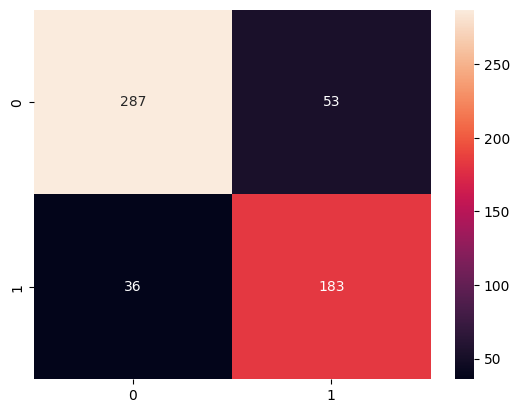

In [59]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d')